In [2]:
!pip install unidecode

     |████████████████████████████████| 245kB 12.6MB/s 


In [3]:
import torch
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('data/shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 5465394


In [4]:
chunk_len = 200
batch_size = 50

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

s altar to protest
    For aye austerity and single life.
  DEMETRIUS. Relent, sweet Hermia; and, Lysander, yield
    Thy crazed title to my certain right.
  LYSANDER. You have her father's love, Demet


In [0]:
from torch.autograd import Variable


In [6]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)
print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [0]:
def random_training_set(chunk_len, batch_size, file):
    inp = torch.LongTensor(batch_size, chunk_len)
    target = torch.LongTensor(batch_size, chunk_len)
    for bi in range(batch_size):
        start_index = random.randint(0, len(file) - chunk_len)
        end_index = start_index + chunk_len + 1
        chunk = file[start_index:end_index]
        inp[bi] = char_tensor(chunk[:-1])
        target[bi] = char_tensor(chunk[1:])
    inp = Variable(inp)
    target = Variable(target)
    inp= inp.transpose(1,0)
    target = target.transpose(1,0)

    return inp.to(device), target.to(device)

In [0]:
i,o = random_training_set(200, 50, file)

In [10]:
i.shape, o.shape

(torch.Size([200, 50]), torch.Size([200, 50]))

In [0]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F


class RNN(nn.Module):
    def __init__(self, input_size, emb_size, hidden_size, n_layers, dropout):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_size, emb_size)
        self.gru = nn.GRU(emb_size, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, input_size)
        self.drop = nn.Dropout(dropout)
    
    def forward(self, inputs, hidden):

        #inputs = [batch size]

        encoded = self.drop(self.embedding(inputs))

        #encoded = [batch size, emb dim]

        encoded = encoded.unsqueeze(0)

        #encoded = [1, batch size, emb dim]

        output, hidden = self.gru(encoded, hidden)

        #output = [1, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]

        output = self.fc(output)

        #output = [1, batch size, input size]

        output = output.view(-1, self.input_size)

        #output = [1*batch size, input size]

        return output, hidden
        
    def init_hidden(self, batch_size):

        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [0]:

hidden_size = 256
emb_size = 128
n_layers = 2
lr = 0.005
dropout = 0.3

model = RNN(n_characters, emb_size, hidden_size, n_layers, dropout)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [0]:
model = model.to(device)
criterion = criterion.to(device)

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 729,700 trainable parameters


In [0]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
def train(inp, target):
    hidden = model.init_hidden(batch_size)
    hidden = hidden.to(device)
    optimizer.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        loss += criterion(output, target[c])

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

In [0]:
def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, cuda=False):
    hidden = model.init_hidden(1)
    prime_input = Variable(char_tensor(prime_str).unsqueeze(0))
    predicted = prime_str

    hidden = hidden.to(device)
    prime_input = prime_input.to(device)
    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = model(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    inp = inp.to(device)

    for p in range(predict_len):
        output, hidden = model(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = Variable(char_tensor(predicted_char))
        inp = inp.to(device)

    return predicted

In [18]:
generate(model, 'Wh', 100)

'Wh::iHv[@A"0=NGOYRwjB($\n^+,\'7_e6O\r\\/wU>_K4>L]$\r%m>_70h`; y0 ->=v \'[Mj@1y7;6hRzP@py7IJ{_W5^)<P;-J:4)Y&>'

In [19]:
n_epochs = 2000
print_every = 100
plot_every = 10


start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set(chunk_len, batch_size, file))       
    loss_avg += loss

    if epoch % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(generate(model, 'Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

0m 34s (100 5%) 1.7407
Whis hor maysests'd from and to case, so sprey do munkined adlear conferieron
    and the hartures the 

1m 8s (200 10%) 1.5463
Wher their son the save,
    For a generain give me you.
  PASSALON. Words! Why, for the streaty, more 

1m 42s (300 15%) 1.5218
Which a merry beard him thee than asters,
    A die most prove, their starf away.
    This a like, do  

2m 16s (400 20%) 1.3153
Wheres of thy judge
    That, but lose the last and she respect call the sinness in her heaven which
  

2m 50s (500 25%) 1.3509
Whe possifity. Sir Troy the
    times shall for thou are before the wing, and trible.

    So head to  

3m 24s (600 30%) 1.2941
Whe done to strange the sert.
  WILLIAM
SHAMPHALLEMPLE. There sours. What
    Than to had be so now an 

3m 58s (700 35%) 1.2742
When me in heaven be and easy man he shall nature born.
    She spurning was not says slepper of my sl 

4m 32s (800 40%) 1.3175
Wher life,
    For the triumph's worth will further eyes a praise of men.
 

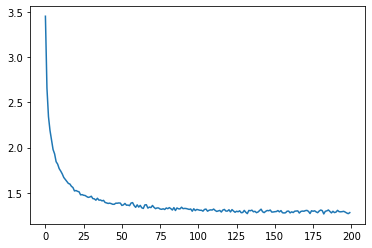

In [26]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [27]:
all_losses

[3.451211639404297,
 2.6565270233154292,
 2.340855194091797,
 2.1877010040283205,
 2.081510055541992,
 1.9775684204101567,
 1.9300117187499997,
 1.8431220092773433,
 1.8161417236328128,
 1.7665685729980471,
 1.739521499633789,
 1.7084078826904296,
 1.668901580810547,
 1.6470437164306642,
 1.6257487182617187,
 1.6030997161865237,
 1.5961676483154297,
 1.5713032989501952,
 1.5575265350341794,
 1.5198209838867187,
 1.5245289916992184,
 1.5155142669677732,
 1.5103032379150392,
 1.47675634765625,
 1.4790421752929686,
 1.4720307312011718,
 1.4691592712402344,
 1.4576027832031246,
 1.4487079162597658,
 1.4526519012451171,
 1.4613454589843748,
 1.4354214935302736,
 1.4322088623046876,
 1.4176626586914063,
 1.439006362915039,
 1.417789566040039,
 1.420164306640625,
 1.410012756347656,
 1.4157041473388672,
 1.3928342895507815,
 1.3878683624267578,
 1.3816539001464843,
 1.3849233856201173,
 1.3798448944091797,
 1.372448715209961,
 1.372226593017578,
 1.3844587707519531,
 1.384092071533203,
 1.387

In [40]:
i='PROJECT GUTEN'
print(generate(model, i, 100), '\n')

PROJECT GUTENBERG ETEXT OF ILLINOS SENERCTIUS
                                     Enter SERVANT

  Hor. A will s 

